     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00


100%|██████████| 38.2M/38.2M [00:36<00:00, 1.04MB/s]


Epoch 1: Train Acc=0.4620, Val Acc=0.6660
Epoch 2: Train Acc=0.7324, Val Acc=0.7420
Epoch 3: Train Acc=0.7972, Val Acc=0.7660
Epoch 4: Train Acc=0.8338, Val Acc=0.7820
Epoch 5: Train Acc=0.8540, Val Acc=0.7700
Epoch 6: Train Acc=0.8680, Val Acc=0.8040
Epoch 7: Train Acc=0.8882, Val Acc=0.7960
Epoch 8: Train Acc=0.9002, Val Acc=0.7840
Epoch 9: Train Acc=0.9128, Val Acc=0.8080
Epoch 10: Train Acc=0.9192, Val Acc=0.8120


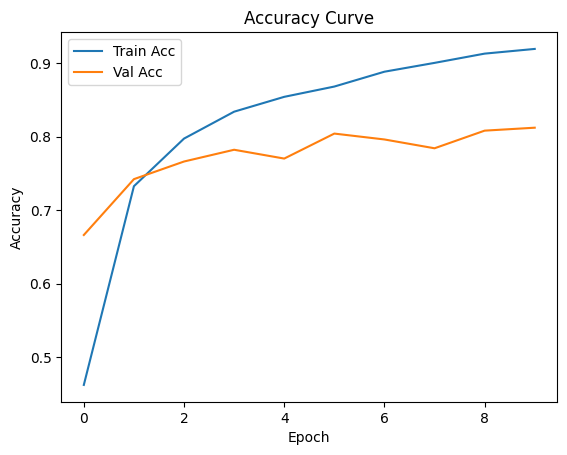

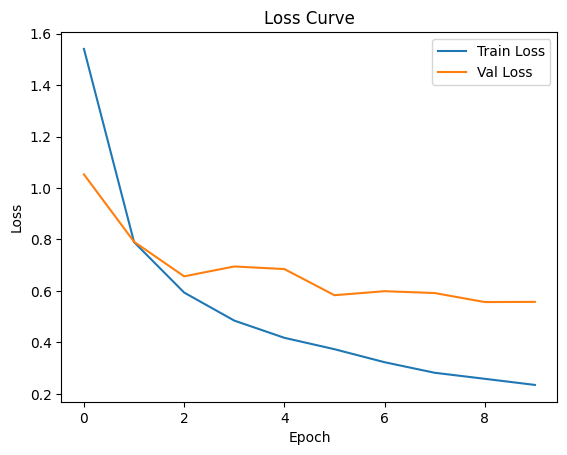

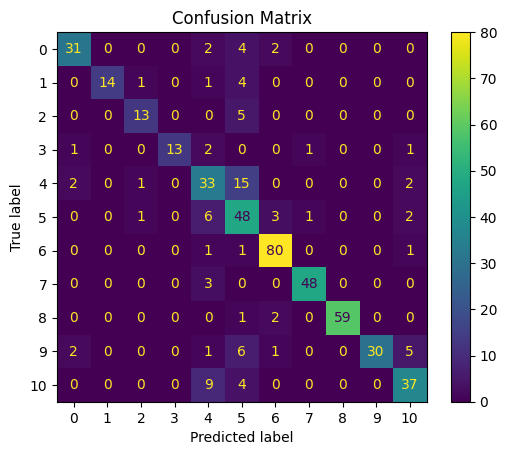

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.83        39
           1       1.00      0.70      0.82        20
           2       0.81      0.72      0.76        18
           3       1.00      0.72      0.84        18
           4       0.57      0.62      0.59        53
           5       0.55      0.79      0.64        61
           6       0.91      0.96      0.94        83
           7       0.96      0.94      0.95        51
           8       1.00      0.95      0.98        62
           9       1.00      0.67      0.80        45
          10       0.77      0.74      0.76        50

    accuracy                           0.81       500
   macro avg       0.86      0.78      0.81       500
weighted avg       0.84      0.81      0.82       500

Per-Class AUCs: [0.981  0.9816 0.9915 0.997  0.9461 0.9514 0.9953 0.9986 0.999  0.9852
 0.9697]
Z-test: Z=3.20, p=0.0007
T-test: t=0.96, p=0.3487
ANOVA: F=0.00, p=

In [2]:
# STEP 1: SETUP
!pip install -q medmnist torch torchvision scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from scipy.stats import ttest_ind, f_oneway, norm
from medmnist.dataset import OrganMNISTAxial
from medmnist import INFO

# DEVICE SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA LOADING
transform = transforms.Compose([transforms.ToTensor()])
full_train = OrganMNISTAxial(split='train', transform=transform, download=True)
test_set = OrganMNISTAxial(split='test', transform=transform, download=True)

# Use 5000 training and 500 test images
train_subset, _ = random_split(full_train, [5000, len(full_train) - 5000])
test_subset, _ = random_split(test_set, [500, len(test_set) - 500])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# CNN MODEL
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 11)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# TRAIN FUNCTION
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
    acc = correct / len(loader.dataset)
    return running_loss / len(loader), acc

# EVAL FUNCTION
def evaluate(model, loader, criterion):
    model.eval()
    loss, correct = 0.0, 0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    acc = correct / len(loader.dataset)
    return loss / len(loader), acc, np.array(all_labels), np.array(all_probs)

# TRAINING
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# PLOTS
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy Curve"); plt.legend(); plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss Curve"); plt.legend(); plt.show()

# FINAL EVAL
val_loss, val_acc, true_labels, probs = evaluate(model, test_loader, criterion)
pred_labels = np.argmax(probs, axis=1)

# CONFUSION MATRIX
ConfusionMatrixDisplay(confusion_matrix(true_labels, pred_labels)).plot()
plt.title("Confusion Matrix")
plt.show()

# CLASSIFICATION REPORT
print("Classification Report:\n", classification_report(true_labels, pred_labels))

# AUC-ROC
try:
    y_true_bin = np.eye(11)[true_labels]
    aucs = [roc_auc_score(y_true_bin[:,i], probs[:,i]) for i in range(11)]
    print("Per-Class AUCs:", np.round(aucs, 4))
except Exception as e:
    print("AUC-ROC failed:", str(e))

# Z-TEST (against benchmark accuracy 75%)
benchmark = 0.75
n = len(true_labels)
z = (val_acc - benchmark) / np.sqrt((benchmark * (1 - benchmark)) / n)
p_z = 1 - norm.cdf(abs(z))
print(f"Z-test: Z={z:.2f}, p={p_z:.4f}")

# T-TEST (train vs val accuracy over epochs)
t_stat, p_t = ttest_ind(train_accs, val_accs)
print(f"T-test: t={t_stat:.2f}, p={p_t:.4f}")

# ANOVA (simulate accuracy from 3 training runs)
acc_run1 = train_accs
acc_run2 = [x + np.random.normal(0, 0.01) for x in train_accs]
acc_run3 = [x + np.random.normal(0, 0.01) for x in train_accs]
f_stat, p_a = f_oneway(acc_run1, acc_run2, acc_run3)
print(f"ANOVA: F={f_stat:.2f}, p={p_a:.4f}")




In [3]:
# SAVE & LOAD
torch.save(model.state_dict(), "organmnist_cnn.pt")  # Fixed closing quotation mark
model2 = SimpleCNN().to(device)
model2.load_state_dict(torch.load("organmnist_cnn.pt"))
model2.eval()


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=11, bias=True)
  )
)